# Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import seaborn as sns
import yaml
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from typing import List
from rdkit import Chem
from rdkit.Chem import Descriptors

repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

from alinemol.utils import eval_roc_auc, eval_pr_auc, eval_acc, rescale, compute_linear_fit
from alinemol.utils import plot_ID_OOD, plot_ID_OOD_sns #visualize_chemspace
from alinemol.utils import split_molecules_train_test, split_molecules_train_val_test
from alinemol.utils import compare_rankings

In [2]:
#from alinemol.splitters import ScaffoldSplit, RandomSplit, SphereExclusionSplit, KMeansSplit, DBScanSplit, OptiSimSplit

#light_color = plt.get_cmap("plasma").colors[170]
#dark_color = plt.get_cmap("plasma").colors[5]
#dark_color = "black"


#matplotlib.use("pgf")

# Set matplotlib parameters
rcparams = {
    # LaTeX setup
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "pgf.rcfonts": False,
    
    # Font settings
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
    
    # Figure settings
    "figure.dpi": 300,  # Higher DPI for better quality
    "figure.figsize": [6.4, 4.8],  # Default figure size
    "figure.constrained_layout.use": True,  # Better layout handling
    
    # Axes settings
    "axes.linewidth": 1.0,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    
    # Legend settings
    "legend.fontsize": 14,
    "legend.frameon": True,
    "legend.loc": "upper right",
    
    # Tick settings
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}
matplotlib.rcParams.update(rcparams)

# Seaborn settings
sns.set_style("whitegrid", rc=rcparams)
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)

In [3]:
# Load the configuration file (wich contains datasets, models, and splitting)
CFG = yaml.safe_load(open(os.path.join(DATASET_PATH, "config.yml"), "r"))

ML_MODELS: List = CFG["models"]["ML"]
GNN_MODELS: List = CFG["models"]["GNN"]["scratch"]
PRETRAINED_GNN_MODELS: List = CFG["models"]["GNN"]["pretrained"]
ALL_MODELS: List = [ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS]
DATASET_NAMES: List = CFG["datasets"]["TDC"]
SPLIT_TYPES: List = CFG["splitting"]    


# read the results that are saved in the results folder. This is used for the visualization
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv")) 
results["model_type"] = results['model'].apply(lambda x: "Classical_ML" if x in ML_MODELS else "GNN")
metric_mapping = {'accuracy': 'Accuracy', 'roc_auc': 'ROC-AUC', 'pr_auc': 'PR-AUC'}


# Visualize the splits in 2D

In [ ]:
# Function for visulizing the chemical space (available in utils/plot_utils.py)
import umap
import datamol as dm
from typing import List

def visualize_chemspace(
    data: pd.DataFrame, split_names: List[str], mol_col: str = "smiles", size_col=None, size=10, normalize=False
) -> None:
    """
    Visualize chemical space using UMAP

    Args:
        data (pd.DataFrame): pd.DataFrame with columns "smiles", "label", "split"
        split_names (list): list of split names
        mol_col (str): name of column containing SMILES
        size_col: name of column containing size information

    Returns:
        None

    Note:
        This UMAP embedding is based on the Morgan fingerprint of the molecules (r=2, n=2048)
    """
    features = [dm.to_fp(mol) for mol in data[mol_col]]
    if normalize:
        features = StandardScaler().fit_transform(features)
    embedding = umap.UMAP().fit_transform(features)
    print(embedding.shape)
    data["UMAP_0"], data["UMAP_1"] = embedding[:, 0], embedding[:, 1]
    for split_name in split_names:
        plt.figure(figsize=(10, 6))
        fig = sns.scatterplot(
            data=data, x="UMAP_0", y="UMAP_1", s=size, style=size_col, hue=split_name, alpha=0.5, hue_order=["Train", "Test"]
        )
        fig.set_title(f"UMAP Embedding of compounds for {split_name} split", fontsize=20)
        fig.legend(loc="upper right")
        plt.show()

In [36]:
index = 0
dataset_categoty = "TDC"
dataset_name = "AMES"
split_types = ["scaffold", "molecular_weight", "kmeans", "max_dissimilarity", "perimeter", "molecular_logp"]

dfs = []
for i, split_type in enumerate(split_types):
    # Load the dataset
    train_df = pd.read_csv(os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type, f"train_{index}.csv"))
    print(train_df.shape)
    test_df  = pd.read_csv(os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type, f"test_{index}.csv"))
    print(test_df.shape)
    train_test_list = ["Train"]*len(train_df) + ["Test"]*len(test_df)
    df = pd.concat([train_df, test_df])
    df[split_type] = train_test_list
    print(df.shape)
    dfs.append(df)
    if i != 0:
        df = pd.merge(dfs[0], df, on=["smiles", "label"], how="outer")
        dfs[0] = df


(5564, 2)
(1593, 2)
(7157, 3)
(6441, 2)
(716, 2)
(7157, 3)
(6724, 2)
(433, 2)
(7157, 3)
(6261, 2)
(896, 2)
(7157, 3)
(4878, 2)
(2279, 2)
(7157, 3)


In [37]:
df

,smiles,label,scaffold,molecular_weight,kmeans,max_dissimilarity,perimeter
0,Br/C=C/Br,1,Train,Train,Train,Test,Test
1,BrC(Br)Br,1,Train,Train,Train,Test,Test
2,BrC(Br)C(Br)(Br)Br,0,Train,Test,Train,Test,Test
3,BrC(Br)C(Br)Br,0,Train,Train,Train,Test,Test
4,BrC/C=C\CBr,1,Train,Train,Train,Test,Test
...,...,...,...,...,...,...,...
7152,c1cnccn1,0,Train,Train,Train,Test,Test
7153,c1csc(-c2nc(N3CCOCC3)c3ccccc3n2)c1,1,Train,Train,Train,Train,Train
7154,c1cscn1,0,Train,Train,Train,Test,Test
7155,c1scc2c1-c1cscc1C1NC21,1,Train,Train,Train,Train,Train


In [38]:
(df['scaffold'] == "Test").sum() / len(df), (df['scaffold'] == "Train").sum() / len(df)

(0.2225792929998603, 0.7774207070001398)

In [39]:
#import umap.plot
#umap.plot.points(features, labels=label)

In [ ]:
visualize_chemspace(df, split_names=split_types, size=14, normalize=False)

In [4]:
dataset_categoty = "TDC"
dataset_name = "CYP2C19"
split_type = "scaffold"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type)

train_path = os.path.join(SPLIT_PATH, "train_0.csv")
test_path = os.path.join(SPLIT_PATH, "test_0.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [8]:
train_test_list = ["train"]*len(train_df) + ["test"]*len(test_df)
split_df = pd.concat([train_df, test_df])
split_df[split_type] = train_test_list

In [11]:
split_df[split_type].value_counts()

scaffold
train    10026
test      2587
Name: count, dtype: int64

In [12]:
split_df

,smiles,label,scaffold
0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,train
1,Clc1ccccc1-c1n[nH]c(-c2ccccc2)n1,1,train
2,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1,train
3,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1,train
4,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,0,train
...,...,...,...
2582,O=C1C2=CCc3c(c(O)n(-c4ccc(F)cc4F)c3O)[C@H]2[C@...,0,test
2583,O=C1C2=CCc3c(c(O)n(C4CCCCC4)c3O)[C@@H]2[C@H](O...,0,test
2584,O=C1[C@H]2O[C@@H]2[C@@H](O)[C@H]2[C@H]1CCn1c(=...,0,test
2585,Oc1c2c(c(O)n1Cc1ccccc1)[C@H]1C(=CC2)C2(OCCCO2)...,0,test


In [17]:
import datamol as dm
import splito

In [18]:
DF_PATH = os.path.join(DATASET_PATH, "TDC", "CYP2C19", "CYP2C19_simplified.csv")
data = pd.read_csv(DF_PATH)
data.shape

(12665, 2)

In [19]:
# Define scaffold split
splitter = splito.ScaffoldSplit(smiles=data.smiles.tolist(), n_jobs=-1, test_size=0.1, random_state=111)

In [20]:
train_idx, test_idx = next(splitter.split(X=data["smiles"].values))
assert train_idx.shape[0] > test_idx.shape[0]

In [21]:
data.loc[train_idx, "ScaffoldSplit"] = "train"
data.loc[test_idx, "ScaffoldSplit"] = "test"
data["scaffold"] = splitter.scaffolds

In [22]:
data["ScaffoldSplit"].value_counts()

ScaffoldSplit
train    11414
test      1251
Name: count, dtype: int64

In [ ]:
visualize_chemspace(data, split_names=["ScaffoldSplit"], size=10)

In [25]:
data

,smiles,label,ScaffoldSplit,scaffold,UMAP_0,UMAP_1
0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0,train,c1ccc(N2CCNCC2)cc1,9.557853,3.139632
1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1,train,O=c1oc2ccc(NS(=O)(=O)c3cccs3)cc2s1,7.717187,1.656112
2,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1,train,c1ccc(-c2n[nH]c(-c3ccccc3)n2)cc1,9.522059,0.786873
3,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1,train,c1ccc(C(c2nnn[nH]2)N2CCN(Cc3ccncc3)CC2)cc1,9.813725,0.699903
4,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1,train,O=C(Cn1nnc(-c2ccncc2)n1)NCc1ccccc1,8.179121,3.715858
...,...,...,...,...,...,...
12660,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,0,train,O=C1NC(=O)[C@@H]2CC[C@@H]3C(=O)C=CC[C@H]3[C@H]12,5.097229,16.109467
12661,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,0,train,O=C1[C@H]2[C@H](CC=C3[C@H]2C[C@H]2O[C@@H]2C32O...,6.363259,3.586334
12662,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,1,test,O=C1NC(=O)[C@H]2CC=C3[C@@H](C[C@H]4O[C@@H]4C34...,6.338778,3.489323
12663,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,0,train,O=C1CCC[C@H]2[C@@H]3C(=O)N(Cc4ccccc4)C(=O)[C@@...,5.342569,16.228552


In [14]:
visualize_chemspace(data, split_names=["ScaffoldSplit"], mol_col="scaffold")

NameError: name 'data' is not defined

In [ ]:
# Define PerimeterSplit
splitter = splito.PerimeterSplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data["smiles"].values))

assert train_idx.shape[0] > test_idx.shape[0]

data.loc[train_idx, splito.PerimeterSplit.__name__] = "train"
data.loc[test_idx, splito.PerimeterSplit.__name__] = "test"

In [ ]:
# Define PerimeterSplit
splitter = splito.MaxDissimilaritySplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data.smiles.values))
assert train_idx.shape[0] > test_idx.shape[0]

data.loc[train_idx, "MaxDissimilaritySplit"] = "train"
data.loc[test_idx, "MaxDissimilaritySplit"] = "test"

In [ ]:
visualize_chemspace(data, split_names=["PerimeterSplit", "MaxDissimilaritySplit"])

##

# K- Nearest Dataset Distance

In [4]:
from alinemol.utils.split_utils import retrieve_k_nearest_neighbors_TMD, retrieve_k_nearest_neighbors_Tanimoto, train_test_dataset_distance_retrieve, sklearn_stratified_random_split
from tqdm import tqdm

cfg = yaml.safe_load(open(os.path.join("datasets", "config.yml"), "r"))
datasets = cfg["datasets"]["TDC"]
splitting = cfg["splitting"]
#splitting = ["scaffold"]
index = np.arange(10)

df_list = []
for split in tqdm(splitting):
    for dataset in datasets:
        original_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, f"{dataset}_standardize.csv"))
        pairwise_distance_jaccard = np.load (os.path.join(DATASET_PATH, "TDC", dataset, f"Jaccard_distance.npy"))
        pairwise_distance_tmd = np.load (os.path.join(DATASET_PATH, "TDC", dataset, f"TMD_distance.npy"))
        for idx in index: 
            id_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"train_{idx}.csv"))
            X, y = np.array(id_df["smiles"]), np.array(id_df["label"])
            X_train, X_val, X_test, y_train, y_val, y_test = sklearn_stratified_random_split(X, y, (0.72, 0.08, 0.2))
            train_df = pd.DataFrame({"smiles": X_train, "label": y_train})
            test_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"test_{idx}.csv"))
            tanimoto_vals = retrieve_k_nearest_neighbors_Tanimoto(pairwise_distance_jaccard, original_df, train_df, test_df, k=5)
            tmd_vals = retrieve_k_nearest_neighbors_TMD(pairwise_distance_tmd, original_df, train_df, test_df, k=5)
            dist_df = pd.DataFrame({"tanimoto": tanimoto_vals, "tmd": tmd_vals, "split": split, "dataset": dataset, "index": idx})
            df_list.append(dist_df)

dist_df = pd.concat(df_list)
dist_df

100%|██████████| 8/8 [05:13<00:00, 39.15s/it]


,tanimoto,tmd,split,dataset,index
0,0.186047,127.35,random,CYP1A2,0
1,0.750000,173.02,random,CYP1A2,0
2,0.531250,159.35,random,CYP1A2,0
3,0.606061,119.19,random,CYP1A2,0
4,0.581818,125.52,random,CYP1A2,0
...,...,...,...,...,...
11015,0.692308,321.15,max_dissimilarity,HERG,9
11016,0.746988,286.91,max_dissimilarity,HERG,9
11017,0.651163,257.66,max_dissimilarity,HERG,9
11018,0.629032,175.97,max_dissimilarity,HERG,9


In [34]:
dist_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", "nearest_distances.csv"))

In [35]:
# First, group based on split and compute Median for each split for jaccard distance. Seond, group based on split and compute Median for each split for TMD distance
jaccard_df = dist_df.groupby(["split"])["tanimoto"].median().reset_index()
tmd_df = dist_df.groupby(["split"])["tmd"].median().reset_index()

In [36]:
categories = jaccard_df["split"].tolist()
condition1 = jaccard_df["tanimoto"].tolist()
condition2 = tmd_df["tmd"].tolist()

# Compare rankings
results = compare_rankings(condition1, condition2, categories)

# Print results
print("\nRanking Comparison Results:")
print(f"Spearman Correlation: {results['spearman_correlation']:.3f} (p-value: {results['spearman_p_value']:.3f})")
print(f"Kendall's Tau: {results['kendall_tau']:.3f} (p-value: {results['kendall_p_value']:.3f})")
print(f"Footrule Distance: {results['footrule_distance']:.0f}")

print("\nDetailed Comparison:")
print(results['comparison_table'].to_string(index=False))


Ranking Comparison Results:
Spearman Correlation: 0.595 (p-value: 0.120)
Kendall's Tau: 0.429 (p-value: 0.179)
Footrule Distance: 10

Detailed Comparison:
                Category  Condition1_Value  Condition2_Value  Rank_Condition1  Rank_Condition2  Rank_Difference
molecular_weight_reverse          0.682540            152.27              1.0              5.0              4.0
       max_dissimilarity          0.679487            176.13              2.0              2.0              0.0
                  kmeans          0.671429            163.63              3.0              4.0              1.0
          molecular_logp          0.631579            175.37              4.0              3.0              1.0
        molecular_weight          0.630769            237.65              5.0              1.0              4.0
        scaffold_generic          0.614286            138.21              6.0              6.0              0.0
                scaffold          0.610390            133.94

In [ ]:
# Plot a Boxplot Figure (1, 2) with two horizontal axis, one for Tanimoto and one for TMD. (x-axis: split, y-axis: distance)
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.1})
sns.boxplot(x="split", y="tanimoto", data=dist_df, hue="split", ax=ax[0])
sns.boxplot(x="split", y="tmd", data=dist_df, hue="split", ax=ax[1], showfliers=False)
#ax[0].set_title("Tanimoto Distance to 5 nearest neighbors", fontsize=20)
#ax[1].set_title("TMD Distance to 5 nearest neighbors", fontsize=20)
ax[0].set_xlabel("", fontsize=20)
ax[1].set_xlabel("", fontsize=20)
ax[0].set_ylabel("Tanimoto Distance", fontsize=20)
ax[1].set_ylabel("TMD", fontsize=20)
ax[0].grid(axis='both', linestyle='--', alpha=0.6)
ax[1].grid(axis='both', linestyle='--', alpha=0.6)
ax[0].tick_params(axis='x', rotation=90, labelsize=16)
ax[1].tick_params(axis='x', rotation=90, labelsize=16)

# put a and b in the top left corner of the first and second subplot (outside the plot)
ax[0].text(-0.05, 1.05, '(a)', transform=ax[0].transAxes, fontsize=20, fontweight='bold')
ax[1].text(-0.05, 1.05, '(b)', transform=ax[1].transAxes, fontsize=20, fontweight='bold')

save = True
# save to pdf and png
if save:
    plt.savefig("assets/distance_distribution.pdf", bbox_inches="tight")
    plt.savefig("assets/distance_distribution.png", bbox_inches="tight", dpi=400)

plt.show()

# Plot performance of ID vs OOD

In [ ]:
# First groupby by the split. Then box plot the differnce between ID_test_roc_auc and OOD_test_roc_auc for each split
# Create a single figure with two subplots
# box plots with the difference between ID and OOD test aggregated by dataset
# heatmap with the difference between ID and OOD test aggregated by dataset and split
metric = 'roc_auc'
perc = False
save = False
metric_mapping = {'accuracy': 'Accuracy', 'roc_auc': 'ROC-AUC', 'pr_auc': 'PR-AUC'}

diff = results[f"ID_test_{metric}"] - results[f"OOD_test_{metric}"]
results['difference'] = diff
# Create a single figure with two subplots with more horizontal space between them
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.1})

# First subplot - Boxplot
sns.boxplot(x="split", y="difference", data=results, hue="split", ax=ax1, showfliers=True)
ax1.tick_params(axis='x', rotation=90, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_title(f"Difference between ID and OOD test {metric_mapping[metric]}", fontsize=20)
ax1.set_xlabel("", fontsize=24)
ax1.set_ylabel(f"$\Delta$ {metric_mapping[metric]}", fontsize=18)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
#ax1.legend().remove()  # Remove redundant legend

# Second subplot - Heatmap
dataset_names = results["dataset"].unique()
split_types = SPLIT_TYPES
df = pd.DataFrame(index=dataset_names, columns=split_types)

# Fill the dataframe
for dataset in dataset_names:
    for split in split_types:
        num = results[(results["dataset"] == dataset) & (results["split"] == split)][f"ID_test_{metric}"].mean()
        den = results[(results["dataset"] == dataset) & (results["split"] == split)][f"OOD_test_{metric}"].mean()
        df.loc[dataset, split] = num - den if not perc else (num - den) / num * 100

df = df.astype(float)

# Plot heatmap
vmin, vmax = 0.0, 0.2
sns.heatmap(df, ax=ax2, cmap="coolwarm", annot=True, fmt=".3f", vmin=vmin, vmax=vmax)
ax2.set_xlabel("", fontsize=24)
ax2.set_ylabel("Data Sets", fontsize=20)
ax2.set_title(f"Difference between ID and OOD test {metric_mapping[metric]}", fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, horizontalalignment="right", fontsize=18)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, horizontalalignment="right", fontsize=18)

# Add subplot labels
ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold')
ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold')

# Adjust layout with bottom margin
plt.subplots_adjust(bottom=0.2)

# Save if needed
if save:
    plt.savefig("assets/box_heatmap_id_ood_comparison_roc_auc.pdf", bbox_inches="tight")
    plt.savefig("assets/box_heatmap_id_ood_comparison_roc_auc.png", bbox_inches="tight", dpi=300)

plt.show()

In [ ]:
# Create grouped bar plot for ML vs GNN model differences
save = True

results["model_type"] = results['model'].apply(lambda x: "Classical_ML" if x in ML_MODELS else "GNN")

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(3, 4, height_ratios=[2, 1, 1])  # 3 rows, 4 columns

# First row: One wide subplot
ax1 = plt.subplot(gs[0, :])  # Spans all columns

# Second and third rows: 4x2 grid (8 subplots)
axes = [plt.subplot(gs[i, j]) for i in range(1, 3) for j in range(4)]


df = results.groupby(['split', 'model_type', 'dataset'])['difference'].mean().reset_index()

# rearrange the order of the split
split_order = SPLIT_TYPES
df['split'] = pd.Categorical(df['split'], split_order)

# For ax1, plot the difference between ML and GNN models
g = sns.barplot(x="split", y="difference", hue="model_type", data=df, ax=ax1, legend=True)
ax1.set_title(f"Difference between ID and OOD test {metric_mapping[metric]}", fontsize=20)
ax1.set_xlabel("", fontsize=24)
ax1.set_ylabel(f" $\Delta$ {metric_mapping[metric]}", fontsize=16)
ax1.tick_params(axis='x', rotation=10, labelsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
# Move the legend outside the plot
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)




# for each dataset, create a small figure with the same plot
for i, dataset in enumerate(dataset_names):
    df_dataset = df[df["dataset"] == dataset]
    g = sns.barplot(x="split", y="difference", hue="model_type", data=df_dataset, ax=axes[i])


    # Customize the plot
    #axes[i].set_title(f"Difference between ID and OOD test {metric_mapping[metric]}", fontsize=20)
    # put x axis tixks just on the last rows and ignore other rows
    if i < 4:
        axes[i].set_xticklabels([])
    else:
        axes[i].tick_params(axis='x', rotation=90, labelsize=12, )
    axes[i].set_title(f"{dataset}", fontsize=16)
    axes[i].set_xlabel("", fontsize=18)
    axes[i].set_ylabel(f"$\Delta$ {metric_mapping[metric]}", fontsize=12)
    axes[i].grid(axis='both', linestyle='--', alpha=0.6)

    # Adjust legend
    g.legend().remove()  # Remove redundant legend
    # limit the range of yaxis betwen -0.1 to 0.15 with 0.05 interval
    axes[i].set_ylim(-0.15, 0.15)
    axes[i].set_yticks(np.arange(-0.15, 0.16, 0.05))
    # remove y label for all subplots except the first one
    if i % 4 != 0:
        axes[i].set_ylabel("")

# add (a) to the first row, and (b) for other rows
ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold')
axes[0].text(-0.55, 1.25, f'(b)', transform=axes[0].transAxes, fontsize=20, fontweight='bold')

# Adjust layout to prevent label cutoff
plt.tight_layout()
if save:
    plt.savefig("assets/grouped_barplot_ml_gnn_difference.pdf", bbox_inches="tight")
    plt.savefig("assets/grouped_barplot_ml_gnn_difference.png", bbox_inches="tight", dpi=300)

plt.show()

In [ ]:

for split in SPLIT_TYPES:
    print(f"\nSplit: {split}")
    df_subset = results[results["split"] == split]

    # run statistical test on difference columns based on model types
    from scipy.stats import ttest_ind
    ml_diff = df_subset[df_subset["model_type"] == "Classical_ML"]["difference"]
    gnn_diff = df_subset[df_subset["model_type"] == "GNN"]["difference"]
    t_stat, p_value = ttest_ind(ml_diff, gnn_diff)
    print(f"t-statistic: {t_stat:.5f}, p-value: {p_value:.5f}")

    # Interpret results
    alpha = 0.01  # conventional significance level
    print("\nInterpretation:")
    if p_value < alpha:
        print(f"Since p-value ({p_value:.4f}) is less than {alpha}, there is a significant difference between the categories")
    else:
        print(f"Since p-value ({p_value:.4f}) is greater than {alpha}, there is no significant difference between the categories")


In [ ]:
from alinemol.utils.plot_utils import heatmap_plot_all_dataset
#matplotlib.rcParams['figure.autolayout'] = True
heatmap_plot_all_dataset(results=results, metric="roc_auc", save=True)

# Comparing Two or more splits together

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

save = True
metric= "roc_auc"

def make_regplot(x, y, ax, color="#66c2a5"):
    sns.regplot(x=x, y=y, ax=ax,
                scatter_kws={'alpha':0.5, 's':40},
                line_kws={'color': 'red', 'linewidth': 2},
                ci=95,
                color=color)

    corr = pearsonr(x, y)[0]
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
    ax.text(0.05, 0.95, f'r = {corr:.2f}', 
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=props)

def format_axis(ax):
    #lims = [
    #    np.min([ax.get_xlim(), ax.get_ylim()]),
    #    np.max([ax.get_xlim(), ax.get_ylim()])
    #]
    lims = [0.5, 0.95]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0, color = "blue")
    # axis interval should be 0.1 and not 0.2
    ax.set_xticks(np.arange(0.5, 1.0, 0.1))
    ax.set_yticks(np.arange(0.5, 1.0, 0.1))

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(5, 4, height_ratios=[2, 1, 1, 1, 1], hspace=1.0, wspace=0.3)  # 5 rows, 4 columns

# Add super title
fig.suptitle(f'ID vs OOD Performance Comparison ({metric_mapping[metric]})', 
             fontsize=24, y=0.95)

# First row: One wide subplot
ax1 = plt.subplot(gs[0, 0:2])  # Spans two columns
ax2 = plt.subplot(gs[0, 2:4])  # Spans two columns

# Second and third rows: 4x2 grid (8 subplots)
ml_axes = [plt.subplot(gs[i, j]) for i in range(1, 5) for j in range(2)]
gnn_axes = [plt.subplot(gs[i, j]) for i in range(1, 5) for j in range(2, 4)]

ML_result = results[results["model_type"] == "Classical_ML"]
GNN_result = results[results["model_type"] == "GNN"]


# Plot main comparisons
make_regplot(ML_result[f"ID_test_{metric}"], ML_result[f"OOD_test_{metric}"], ax1, )
make_regplot(GNN_result[f"ID_test_{metric}"], GNN_result[f"OOD_test_{metric}"], ax2, color="#8da0cb")

# Format main plots
for ax, title in [(ax1, "Classical ML Models"), (ax2, "GNN Models")]:
    ax.set_title(title, fontsize=20, pad=10)
    ax.set_xlabel(f"ID {metric_mapping[metric]}", fontsize=16)
    ax.set_ylabel(f"OOD {metric_mapping[metric]}", fontsize=16)
    if ax == ax2:
        ax.set_ylabel("")
    ax.tick_params(axis='both', labelsize=16)
    format_axis(ax)

# For other axis, plot the same for ML and GNN for each split type
# Plot and format split comparisons
for i, split in enumerate(SPLIT_TYPES):
    ML_split = ML_result[ML_result["split"] == split]
    GNN_split = GNN_result[GNN_result["split"] == split]
    
    make_regplot(ML_split[f"ID_test_{metric}"], ML_split[f"OOD_test_{metric}"], ml_axes[i])
    make_regplot(GNN_split[f"ID_test_{metric}"], GNN_split[f"OOD_test_{metric}"], gnn_axes[i], color="#8da0cb")
    
    # Format split plots
    for ax in [ml_axes[i], gnn_axes[i]]:
        ax.set_title(f"{split}", fontsize=18)
        ax.tick_params(axis='both', labelsize=14)
        format_axis(ax)
        
        # Only show y-label for leftmost plots
        if ax == ml_axes[i] and i%2 == 0:
            ax.set_ylabel(f"OOD {metric_mapping[metric]}", fontsize=12)
        else:
            ax.set_ylabel("")
        
        # Only show x-label for bottom plots
        if i >= len(SPLIT_TYPES) - 2:
            ax.set_xlabel(f"ID {metric_mapping[metric]}", fontsize=12)
        else:
            ax.set_xlabel("")
    
# For the wole plots in row 1, add panel a, For the whole plots on next rows, add panel B
ax1.text(-0.15, 1.05, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold')
ml_axes[0].text(-0.35, 1.15, '(b)', transform=ml_axes[0].transAxes, fontsize=20, fontweight='bold')




# Adjust layout to prevent label cutoff
#plt.tight_layout()
if save:
    plt.savefig("assets/regplot_with_categories.pdf", bbox_inches="tight")
    plt.savefig("assets/regplot_with_categories.png", bbox_inches="tight", dpi=300)
plt.show()


In [ ]:
save = False

from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

def make_regplot(x, y, ax, color='#2E86C1'):
    sns.regplot(x=x, y=y, ax=ax,
                scatter_kws={'alpha':0.5, 's':20, 'color': color},
                line_kws={'color': 'red', 'linewidth': 2},
                ci=95)
    corr = pearsonr(x, y)[0]
    ax.text(0.05, 0.95, f'r = {corr:.2f}', 
            transform=ax.transAxes, fontsize=14)

def format_axis(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])
    ]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)


# Create figure
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(5, 4, height_ratios=[2, 1, 1, 1, 1], hspace=0.4, wspace=0.3)

# Add super title
fig.suptitle(f'ID vs OOD Performance Comparison ({metric_mapping[metric]})', 
             fontsize=24, y=0.95)

# First row: One wide subplot for each model type
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0, 2:4])

# Create subplots for splits
ml_axes = [plt.subplot(gs[i, j]) for i in range(1, 5) for j in range(2)]
gnn_axes = [plt.subplot(gs[i, j]) for i in range(1, 5) for j in range(2, 4)]

# Filter results
ML_result = results[results["model_type"] == "Classical_ML"]
GNN_result = results[results["model_type"] == "GNN"]

# Plot main comparisons
make_regplot(ML_result[f"ID_test_{metric}"], ML_result[f"OOD_test_{metric}"], ax1)
make_regplot(GNN_result[f"ID_test_{metric}"], GNN_result[f"OOD_test_{metric}"], ax2)

# Format main plots
for ax, title in [(ax1, "Classical ML Models"), (ax2, "GNN Models")]:
    ax.set_title(title, fontsize=20, pad=20)
    ax.set_xlabel(f"In-Distribution {metric_mapping[metric]}", fontsize=18)
    ax.set_ylabel(f"Out-of-Distribution {metric_mapping[metric]}", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    format_axis(ax)

# Plot and format split comparisons
for i, split in enumerate(SPLIT_TYPES):
    ML_split = ML_result[ML_result["split"] == split]
    GNN_split = GNN_result[GNN_result["split"] == split]
    
    make_regplot(ML_split[f"ID_test_{metric}"], ML_split[f"OOD_test_{metric}"], ml_axes[i])
    make_regplot(GNN_split[f"ID_test_{metric}"], GNN_split[f"OOD_test_{metric}"], gnn_axes[i])
    
    # Format split plots
    for ax in [ml_axes[i], gnn_axes[i]]:
        ax.set_title(f"{split}", fontsize=20)
        ax.tick_params(axis='both', labelsize=16)
        format_axis(ax)
        
        # Only show y-label for leftmost plots
        if ax == ml_axes[i]:
            ax.set_ylabel(f"OOD {metric_mapping[metric]}", fontsize=14)
        
        # Only show x-label for bottom plots
        if i >= len(SPLIT_TYPES) - 4:
            ax.set_xlabel(f"ID {metric_mapping[metric]}", fontsize=14)

# Add legend
handles = [Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='#2E86C1', markersize=10, label=split)
           for split in SPLIT_TYPES]
fig.legend(handles=handles, loc='center right', 
          bbox_to_anchor=(0.98, 0.5), fontsize=14)

plt.tight_layout()

# Save plots
if save:
    plt.savefig("assets/regplot_with_categories.pdf", 
                bbox_inches="tight", 
                dpi=300,
                metadata={'Creator': 'Your Name',
                         'Title': 'ID vs OOD Performance Comparison'})
    
    plt.savefig("assets/regplot_with_categories.png", 
                bbox_inches="tight", 
                dpi=300)

plt.show()

In [ ]:
# Choose oine specific splitting strategies. Then plot for all the datasets separately the relationship between ID and OOD test roc_auc
split = "max_dissimilarity"

save = True
metric= "roc_auc"

def make_regplot(x, y, ax, color='#66c2a5'):
    sns.regplot(x=x, y=y, ax=ax,
                scatter_kws={'alpha':0.5, 's':40, 'color': color},
                line_kws={'color': 'red', 'linewidth': 2},
                ci=95)

    corr = pearsonr(x, y)[0]
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
    ax.text(0.05, 0.95, f'r = {corr:.2f}', 
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=props)

def format_axis(ax):
    #lims = [
    #    np.min([ax.get_xlim(), ax.get_ylim()]),
    #    np.max([ax.get_xlim(), ax.get_ylim()])
    #]
    lims = [0.5, 0.95]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, 'b--', alpha=0.5, zorder=0)
    ax.set_xticks(np.arange(0.5, 1.0, 0.1))
    ax.set_yticks(np.arange(0.5, 1.0, 0.1))

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(5, 4, height_ratios=[2, 1, 1, 1, 1], hspace=1.0, wspace=0.3)  # 5 rows, 4 columns

# Add super title
fig.suptitle(f'ID vs OOD Performance Comparison ({metric_mapping[metric]})', 
             fontsize=24, y=0.95)

# First row: One wide subplot
ax1 = plt.subplot(gs[0, 0:2])  # Spans two columns
ax2 = plt.subplot(gs[0, 2:4])  # Spans two columns

# Second and third rows: 4x2 grid (8 subplots)
ml_axes = [plt.subplot(gs[i, j]) for i in range(1, 5) for j in range(2)]
gnn_axes = [plt.subplot(gs[i, j]) for i in range(1, 5) for j in range(2, 4)]

ML_result = results[results["model_type"] == "Classical_ML"]
GNN_result = results[results["model_type"] == "GNN"]

ML_result = ML_result[ML_result["split"] == split]
GNN_result = GNN_result[GNN_result["split"] == split]

# Plot main comparisons
make_regplot(ML_result[f"ID_test_{metric}"], ML_result[f"OOD_test_{metric}"], ax1)
make_regplot(GNN_result[f"ID_test_{metric}"], GNN_result[f"OOD_test_{metric}"], ax2, color = "#8da0cb")

# Format main plots
for ax, title in [(ax1, f"Classical ML Models ({split})"), (ax2, f"GNN Models ({split})")]:
    ax.set_title(title, fontsize=20, pad=10)
    ax.set_xlabel(f"ID {metric_mapping[metric]}", fontsize=16)
    ax.set_ylabel(f"OOD {metric_mapping[metric]}", fontsize=16)
    if ax == ax2:
        ax.set_ylabel("")
    ax.tick_params(axis='both', labelsize=16)
    format_axis(ax)

# For other axis, plot the same for ML and GNN for each datasets
# Plot and format datasets comparisons
for i, dataset in enumerate(DATASET_NAMES):
    ML_dataset = ML_result[ML_result["dataset"] == dataset]
    GNN_dataset = GNN_result[GNN_result["dataset"] == dataset]
    
    # plot for the whole dataset in the background
    sns.scatterplot(x=f"ID_test_{metric}", y=f"OOD_test_{metric}", data=ML_result, ax=ml_axes[i], alpha=0.15, s=40, color="gray")
    make_regplot(ML_dataset[f"ID_test_{metric}"], ML_dataset[f"OOD_test_{metric}"], ml_axes[i])
    sns.scatterplot(x=f"ID_test_{metric}", y=f"OOD_test_{metric}", data=GNN_result, ax=gnn_axes[i], alpha=0.15, s=40, color="gray")
    make_regplot(GNN_dataset[f"ID_test_{metric}"], GNN_dataset[f"OOD_test_{metric}"], gnn_axes[i], color = "#8da0cb")
    
    # Format dataset plots
    for ax in [ml_axes[i], gnn_axes[i]]:
        ax.set_title(f"{dataset}", fontsize=18)
        ax.tick_params(axis='both', labelsize=14)
        format_axis(ax)
        
        # Only show y-label for leftmost plots
        if ax == ml_axes[i] and i%2 == 0:
            ax.set_ylabel(f"OOD {metric_mapping[metric]}", fontsize=12)
        else:
            ax.set_ylabel("")
        
        # Only show x-label for bottom plots
        if i >= len(SPLIT_TYPES) - 2:
            ax.set_xlabel(f"ID {metric_mapping[metric]}", fontsize=12)
        else:
            ax.set_xlabel("")
    

# For the wole plots in row 1, add panel a, For the whole plots on next rows, add panel B
ax1.text(-0.15, 1.05, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold')
ml_axes[0].text(-0.35, 1.15, '(b)', transform=ml_axes[0].transAxes, fontsize=20, fontweight='bold')

# Adjust layout to prevent label cutoff
#plt.tight_layout()
if save:
    plt.savefig(f"assets/regplot_{split}_specific_with_categories.pdf", bbox_inches="tight")
    plt.savefig(f"assets/regplot_{split}_with_categories.png", bbox_inches="tight", dpi=300)
plt.show()

# Datasets PhysicoChemical Properties

In [23]:
# Function to compute physicochemical properties
def compute_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            "Molecular_Weight": Descriptors.MolWt(mol),
            "LogP": Descriptors.MolLogP(mol),
            "TPSA": Descriptors.TPSA(mol),
            "HBD": Descriptors.NumHDonors(mol),
            "HBA": Descriptors.NumHAcceptors(mol),
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
        }
    else:
        return {
            "Molecular_Weight": None,
            "LogP": None,
            "TPSA": None,
            "HBD": None,
            "HBA": None,
            "Rotatable_Bonds": None,
        }

# Function to process a dataset
def process_dataset(df):
    properties_df = df["smiles"].apply(compute_properties).apply(pd.Series)
    return pd.concat([df, properties_df], axis=1)

In [24]:
props_df = []
for datasets in DATASET_NAMES:
    df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", datasets, f"{datasets}_standardize.csv"))
    processed_df = process_dataset(df)
    props_df.append(processed_df)


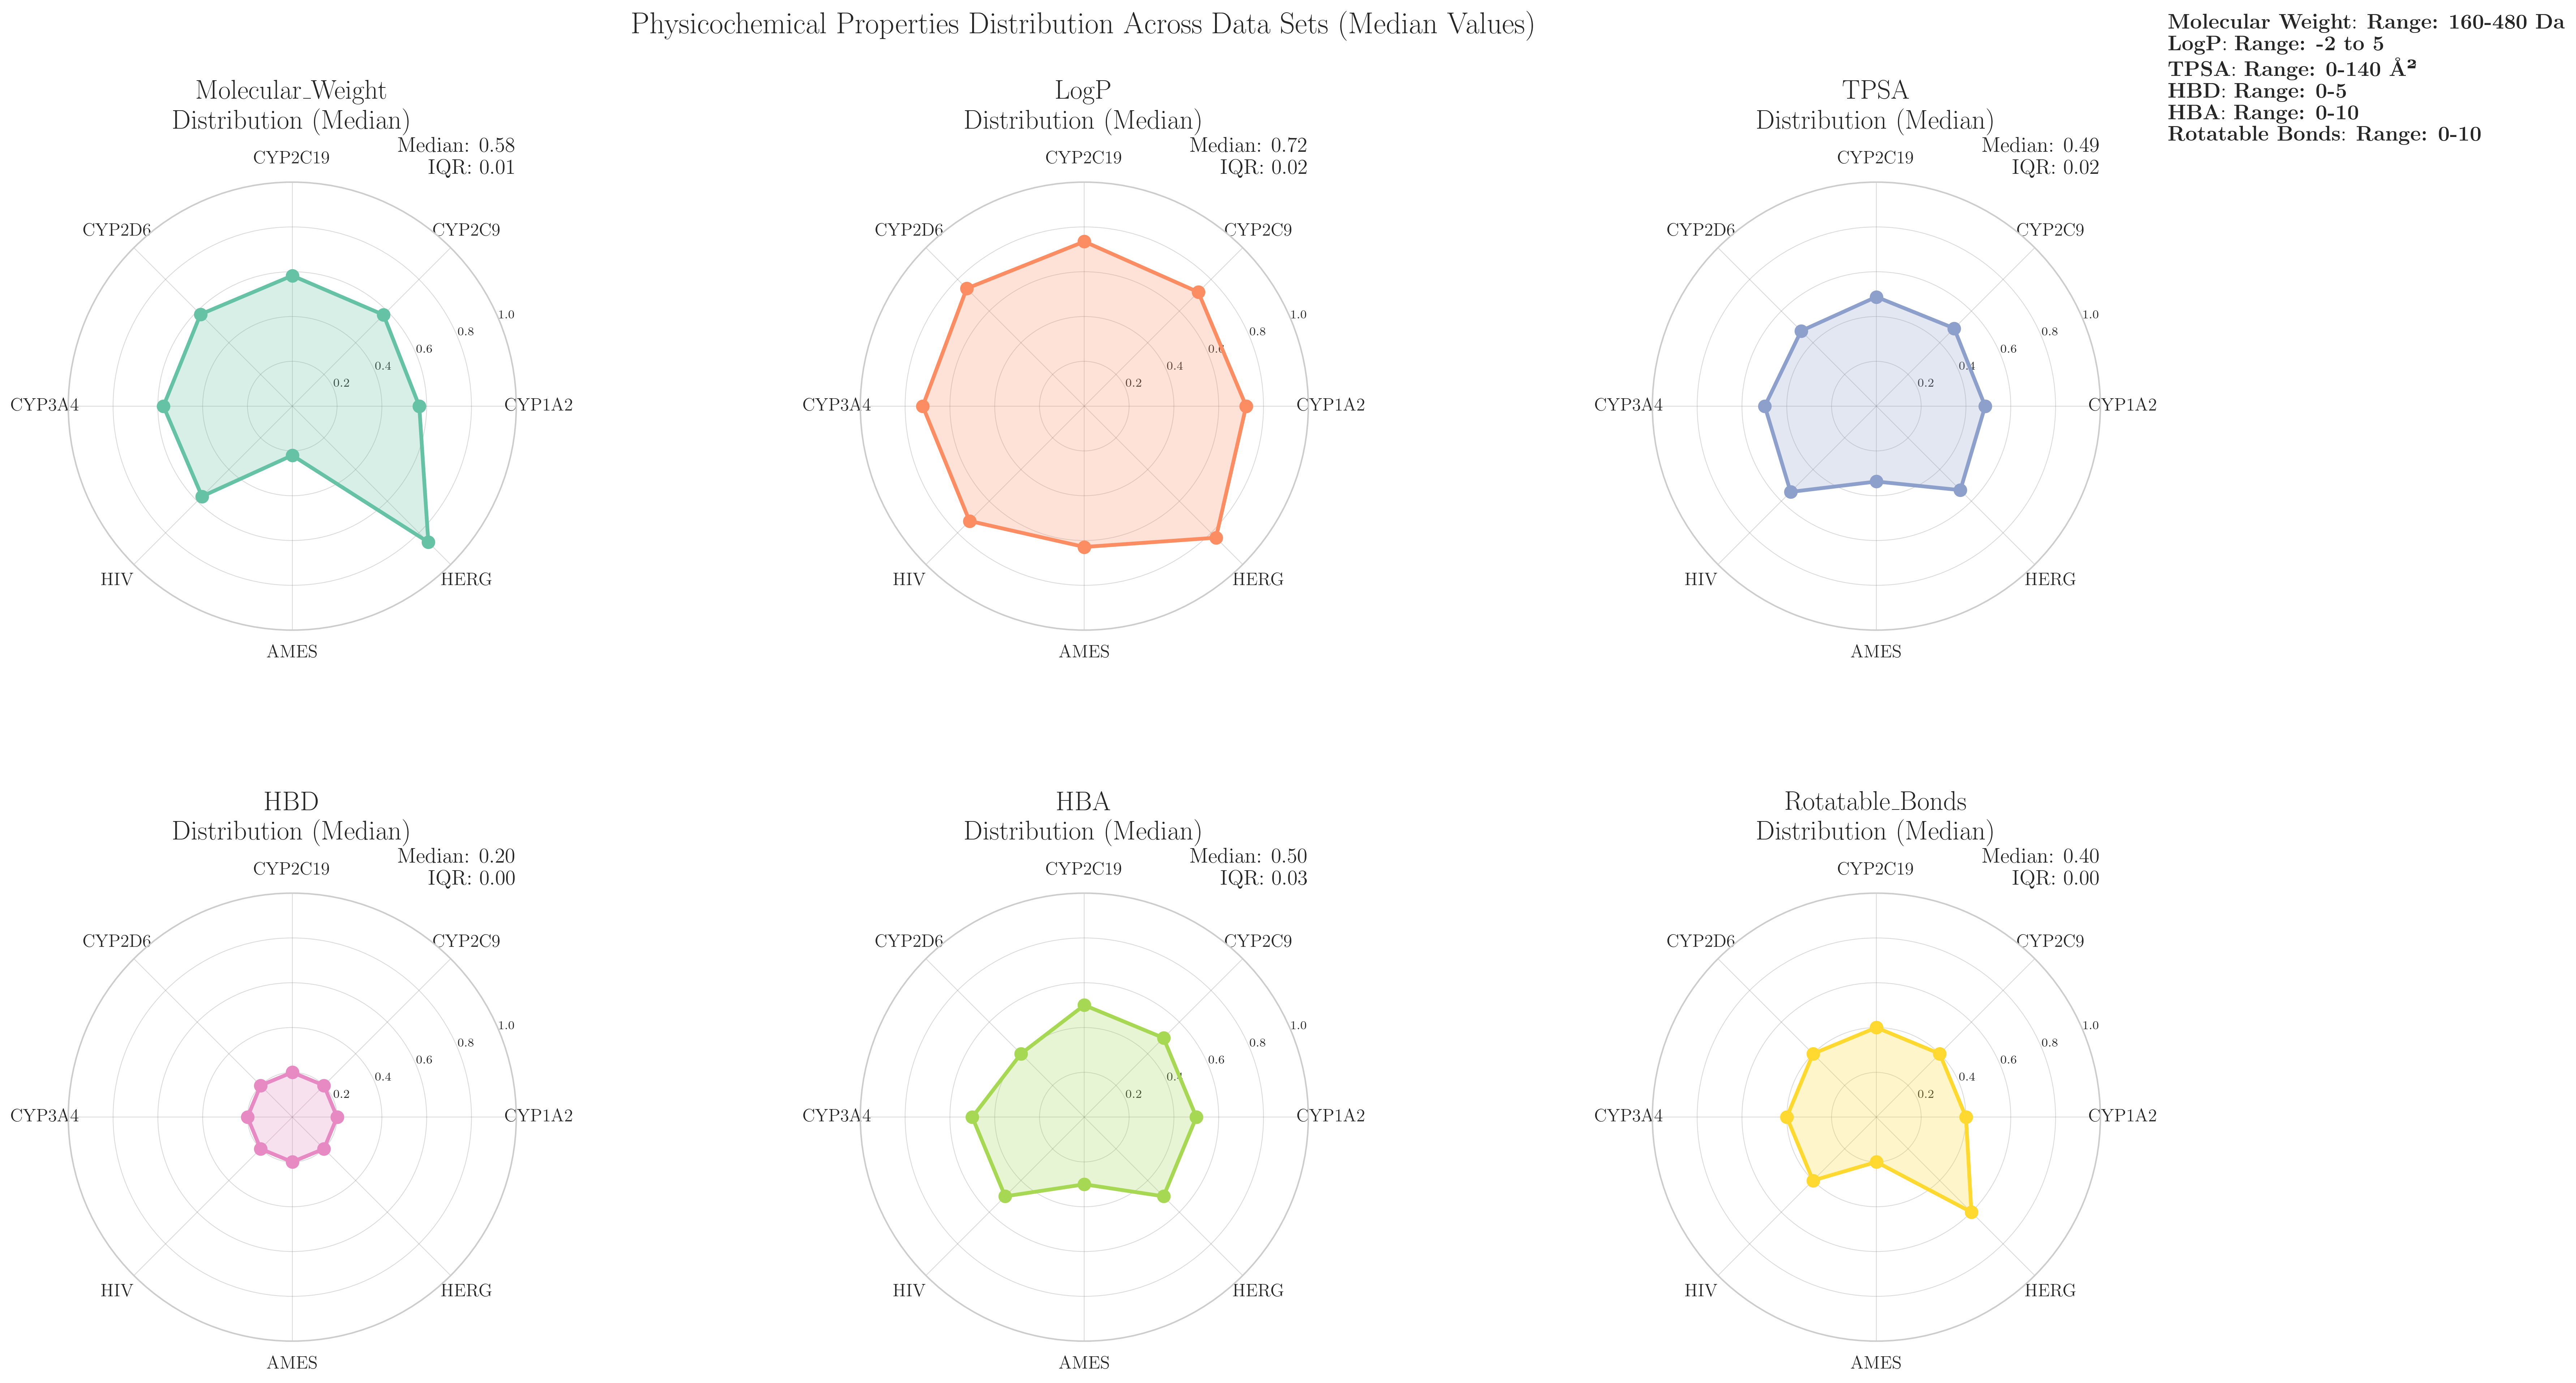

In [33]:
def normalize_property(values, property_name):
    """
    Normalize properties based on their characteristics
    """
    if property_name == "LogP":
        # Center around 0 with typical drug-like range (-2 to 5)
        return (values - (-2)) / (5 - (-2))
    elif property_name == "Molecular_Weight":
        # Normalize based on typical drug-like range (160-480)
        return (values - 160) / (480 - 160)
    elif property_name == "TPSA":
        # Normalize based on typical range (0-140)
        return values / 140
    elif property_name == "HBD":
        # Normalize based on Lipinski's rule (≤5)
        return values / 5
    elif property_name == "HBA":
        # Normalize based on Lipinski's rule (≤10)
        return values / 10
    elif property_name == "Rotatable_Bonds":
        # Normalize based on typical flexibility rule (≤10)
        return values / 10
    else:
        # Default min-max normalization
        return (values - values.min()) / (values.max() - values.min())

def plot_radar_subplots(datasets, save=False):
    properties = ["Molecular_Weight", "LogP", "TPSA", "HBD", "HBA", "Rotatable_Bonds"]
    dataset_names = list(datasets.keys())
    num_datasets = len(dataset_names)
    
    # Create figure with better spacing
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.2, wspace=0.3)
    
    # Use a more distinguishable color palette
    colors = sns.color_palette("Set2")
    
    for i, property_name in enumerate(properties):
        ax = fig.add_subplot(gs[i//3, i%3], projection='polar')
        
        # Collect and normalize median values
        values = [datasets[name][property_name].median() for name in dataset_names]  # Changed to median
        values = normalize_property(np.array(values), property_name)
        
        # Calculate angles
        angles = np.linspace(0, 2*pi, len(dataset_names), endpoint=False)
        
        # Close the radar chart
        values = np.concatenate((values, [values[0]]))
        angles = np.concatenate((angles, [angles[0]]))
        
        # Plot with enhanced styling
        ax.plot(angles, values, 'o-', color=colors[i], linewidth=2.5, markersize=8)
        ax.fill(angles, values, color=colors[i], alpha=0.25)
        
        # Enhance grid and labels
        ax.grid(True, color='gray', alpha=0.3, linewidth=0.5)
        ax.set_xticks(angles[:-1])
        
        # Rotate labels for better readability
        ax.set_xticklabels(dataset_names, rotation=45, fontsize=12)
        
        # Add value markers at specific intervals
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
        
        # Add property statistics (using median and IQR)
        median_val = np.median(values[:-1])
        q1 = np.percentile(values[:-1], 25)
        q3 = np.percentile(values[:-1], 75)
        iqr = q3 - q1
        stats_text = f'Median: {median_val:.2f}\nIQR: {iqr:.2f}'
        ax.text(1.0, 1.1, stats_text, transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
                fontsize=14, ha='right', va='top')
        
        # Enhance title
        ax.set_title(f'{property_name}\nDistribution (Median)', fontsize=18, pad=15, 
                    fontweight='bold')

    # Add main title
    plt.suptitle('Physicochemical Properties Distribution Across Data Sets (Median Values)', 
                 fontsize=20, fontweight='bold', y=1.05)
    
    # Add legend with property ranges
# For the legend text
    legend_text = {
        r"\textbf{Molecular Weight}": r"\textbf{Range: 160-480 Da}",
        r"\textbf{LogP}": r"\textbf{Range: -2 to 5}",
        r"\textbf{TPSA}": r"\textbf{Range: 0-140 Å²}",
        r"\textbf{HBD}": r"\textbf{Range: 0-5}",
        r"\textbf{HBA}": r"\textbf{Range: 0-10}",
        r"\textbf{Rotatable Bonds}": r"\textbf{Range: 0-10}"
    }
    
    fig.text(1.0, 0.95, '\n'.join([f"{k}: {v}" for k, v in legend_text.items()]),
             fontsize=14, transform=fig.transFigure)
    
    if save:
        plt.savefig("assets/radar_subplots.pdf", bbox_inches="tight")
        plt.savefig("assets/radar_subplots.png", bbox_inches="tight", dpi=300)
    plt.show()

datasets = {}
for i, dataset in enumerate(DATASET_NAMES):
    datasets[dataset] = props_df[i]


# Use the function
plot_radar_subplots(datasets, save=True)

# Misc

In [ ]:
from alinemol.utils.plot_utils import heatmap_plot_id_ood
from alinemol.utils.plot_utils import heatmap_plot
heatmap_plot_id_ood(results=results, metric="roc_auc", save=True)
heatmap_plot(results=results, metric="accuracy", save=True)

In [ ]:
from alinemol.utils.plot_utils import heatmap_plot_all_dataset
#matplotlib.rcParams['figure.autolayout'] = True
heatmap_plot_all_dataset(results=results, metric="accuracy", save=True)

In [26]:

results

,ID_test_accuracy,OOD_test_accuracy,ID_test_roc_auc,OOD_test_roc_auc,ID_test_pr_auc,OOD_test_pr_auc,model,test_size,split,dataset,model_type,difference
0,0.699900,0.694057,0.788716,0.786038,0.779051,0.783346,randomForest,2507,random,CYP1A2,Classical_ML,0.002677
1,0.697408,0.694854,0.777776,0.781617,0.767223,0.781373,XGB,2507,random,CYP1A2,Classical_ML,-0.003841
2,0.684447,0.679697,0.766393,0.763114,0.757038,0.756793,SVM,2507,random,CYP1A2,Classical_ML,0.003279
3,0.712861,0.706821,0.793649,0.792888,0.777703,0.783051,GCN,2507,random,CYP1A2,GNN,0.000761
4,0.699900,0.694057,0.795682,0.791416,0.780455,0.776113,GAT,2507,random,CYP1A2,GNN,0.004266
...,...,...,...,...,...,...,...,...,...,...,...,...
7675,0.795603,0.654265,0.875515,0.682525,0.885461,0.602795,Weave,2204,max_dissimilarity,HERG,GNN,0.192990
7676,0.765201,0.658348,0.867237,0.694499,0.873338,0.607955,gin_supervised_edgepred,2204,max_dissimilarity,HERG,GNN,0.172738
7677,0.780168,0.653811,0.880712,0.695003,0.888609,0.622322,gin_supervised_contextpred,2204,max_dissimilarity,HERG,GNN,0.185709
7678,0.788120,0.653358,0.878181,0.687051,0.884670,0.609921,gin_supervised_infomax,2204,max_dissimilarity,HERG,GNN,0.191130
